In [1]:
import momepy as mm
import numpy as np
import numba
import geopandas as gpd
import pandas as pd
import shapely
from sklearn.preprocessing import StandardScaler
from collections import namedtuple
from core.cluster_validation import get_linkage_matrix
from libpysal.graph import read_parquet, Graph
from core.generate_context import spatially_weighted_partial_lag
from core.generate_clusters import preprocess_clustering_data
from sklearn.cluster import AgglomerativeClustering
from core.cluster_validation import get_linkage_matrix
from scipy.cluster.hierarchy import fcluster
from core.utils import used_keys

In [2]:
regions_datadir = "/data/uscuni-ulce/"
morphotopes_dir = '/data/uscuni-ulce/processed_data/morphotopes/'
model_params = '_75_0_None_None_False'
clip = None
to_drop = [
        'stcSAl','stbOri','stcOri','stbCeA',
        'ldkAre', 'ldkPer', 'lskCCo', 'lskERI','lskCWA', 'ltkOri', 'ltkWNB', 'likWBB', 'likWCe',
          'licBAD', 'misBAD',
    'ssbCCM','ssbCCD'    
]


linkage = 'complete'
metric = 'euclidean'

morphotope_stat_columns = ['percentile_25', 'percentile_75', 'mean', 'std']

In [3]:
def preprocess_data(data, scalar, drop_columns=morphotope_stat_columns):
    component_data = data.drop(columns=drop_columns, level=1)
    component_data = component_data.drop(columns=to_drop, level=0)
    component_data.columns =  component_data.columns.get_level_values(0)
    
    component_data = component_data[component_data.index.str[-2:] != '-1']
    
    vals = scalar.fit_transform(component_data)
    component_data = pd.DataFrame(vals, columns=component_data.columns, index=component_data.index)
    component_data = component_data.drop(component_data.columns[component_data.std() == 0], axis=1)
    
    # component_data = component_data[component_data.index >= 0]
    vals = np.nan_to_num(component_data)
    component_data = pd.DataFrame(vals, columns=component_data.columns, index=component_data.index)
    return component_data

def read_region_morphotope_data(region_id, scalar, read_extra=False):
    print('processing' , region_id)
    data = pd.read_parquet(f'{morphotopes_dir}data_morphotopes_{region_id}{model_params}.pq')
    
    data.index = str(region_id) + '_' + data.index
    data = data.iloc[:, :-1]
    component_data = preprocess_data(data, scalar)


    if read_extra:
        extra_chars = pd.read_parquet(f'{morphotopes_dir}morph_chars_{region_id}.pq')
        vals = scalar.fit_transform(extra_chars)
        extra_chars = pd.DataFrame(vals, columns=extra_chars.columns, index=extra_chars.index).fillna(0)
        extra_chars = extra_chars.drop(component_data.columns[component_data.std() == 0], axis=1)
        extra_chars = extra_chars[['limLPS']]
        extra_chars['limLPS2'] = extra_chars['limLPS']

        merged_data = pd.merge(component_data, extra_chars, how='inner', left_index=True, right_index=True)
        pd.testing.assert_index_equal(merged_data.index, component_data.index)
        component_data = merged_data
    
    return component_data

def get_morphotope_linkage(region_data):
    
    clusterer = AgglomerativeClustering(linkage=linkage,
                                        metric=metric,
                                        compute_full_tree=True,
                                        compute_distances=True)
    model = clusterer.fit(region_data)
    linkage_matrix = get_linkage_matrix(model)
    return linkage_matrix


def get_all_clusters(cutoff):
    
    all_clusters = []
    
    for region_id, _ in region_hulls.iterrows():
        data = read_region_morphotope_data(region_id, scalar=StandardScaler())
        region_index = data.index
        linkage_matrix = np.load(f'/data/uscuni-ulce/processed_data/morphotope_linkage/{linkage}_{metric}_{region_id}.npy')
        clusters = fcluster(linkage_matrix, t=cutoff, criterion='distance')
        clusters = pd.Series(clusters, region_index).astype(str)
        clusters = str(region_id) + '_' +clusters
        all_clusters.append(clusters)
    
    all_clusters = pd.concat(all_clusters)
    
    return all_clusters


def read_morphotopes_data(model_params):
    
    data = []
    for region_id, _ in region_hulls.iterrows():
        region_morphotope_data = pd.read_parquet(f'{morphotopes_dir}data_morphotopes_{region_id}{model_params}.pq')
        region_morphotope_data.index = str(region_id) + '_' + region_morphotope_data.index.str[:]
        data.append(region_morphotope_data)
    
    data = pd.concat(data)
    return data

def read_morphotopes_chars():
    
    data = []
    for region_id, _ in region_hulls.iterrows():
        extra_chars = pd.read_parquet(f'{morphotopes_dir}morph_chars_{region_id}.pq')
        data.append(extra_chars)
    
    data = pd.concat(data)
    return data 

def morphotopes_to_etcs(region_id, etcs=True, model_params='_100_0_None_None_False'):


    if etcs:
        etcs = gpd.read_parquet(f'/data/uscuni-ulce/processed_data/tessellations/tessellation_{region_id}.parquet')

    else:
        etcs = gpd.read_parquet(f'/data/uscuni-ulce/processed_data/buildings/buildings_{region_id}.parquet')
        
    etcs['label'] = -1
    
    morphotopes = pd.read_parquet(f'/data/uscuni-ulce/processed_data/morphotopes/tessellation_labels_morphotopes_{region_id}{model_params}.pq')
    morphotopes.loc[:, 'morphotope_label'] =  morphotopes.values[:, 0]

    morph_dict = pd.Series(np.arange(np.unique(morphotopes.values).shape[0]),
                       np.unique(morphotopes.values))
    etcs.loc[morphotopes.index, 'label'] = morphotopes.map(lambda x: morph_dict.loc[x]).values
    etcs['morph'] = str(region_id) + '_' + '-1'
    etcs.loc[morphotopes.index, 'morph'] = str(region_id) + '_' + morphotopes.values
    return etcs

In [4]:

regions_datadir = "/data/uscuni-ulce/"
region_hulls = gpd.read_parquet(
        regions_datadir + "regions/" + "cadastre_regions_hull.parquet"
)

In [5]:
from sklearn.preprocessing import StandardScaler, QuantileTransformer
scalar = QuantileTransformer(subsample=None, output_distribution='uniform')

In [6]:
# # %%time

# ## generate and save linkage matricies for each region
# for region_id, _ in region_hulls.iterrows():
#     data = read_region_morphotope_data(region_id, scalar, read_extra=True)
#     linkage_matrix = get_morphotope_linkage(data)
#     np.save(f'/data/uscuni-ulce/processed_data/morphotope_linkage/{linkage}_{metric}_{region_id}', linkage_matrix)

### Setup regional cutoff to merge regional morphotopes

In [6]:
regional_cutoff = 2.5

In [7]:
regional_clusters = get_all_clusters(cutoff=regional_cutoff)

processing 4
processing 10
processing 132
processing 134
processing 286
processing 313
processing 400
processing 523
processing 765
processing 801
processing 832
processing 913
processing 960
processing 1124
processing 1154
processing 1387
processing 1478
processing 1515
processing 1605
processing 1718
processing 1736
processing 1782
processing 1970
processing 1981
processing 2096
processing 2322
processing 2350
processing 2478
processing 2514
processing 2625
processing 2728
processing 2975
processing 3039
processing 3109
processing 3150
processing 3221
processing 3250
processing 3526
processing 3610
processing 3612
processing 3701
processing 3705
processing 3752
processing 3759
processing 3981
processing 4070
processing 4214
processing 4215
processing 4235
processing 4284
processing 4356
processing 4382
processing 4723
processing 4805
processing 5096
processing 5191
processing 5246
processing 5310
processing 5408
processing 5427
processing 5662
processing 5671
processing 5766
processi

In [8]:
np.unique(regional_clusters).shape

(66494,)

In [9]:
# why are these different  - 

In [22]:
# %%time
morphotopes_data = read_morphotopes_data(model_params)
morphotopes_data = morphotopes_data.loc[regional_clusters.index]
morphotopes_data = morphotopes_data.iloc[:, :-1]

In [23]:
component_data = morphotopes_data.drop(columns=morphotope_stat_columns, level=1)
component_data = component_data.drop(columns=to_drop, level=0)
component_data.columns = component_data.columns.get_level_values(0)
# component_data['sdbCoA'] = morphotopes_data.loc[:, 'sdbCoA']['mean']

In [24]:
%%time
morph_chars_data = read_morphotopes_chars()
morph_chars_data = morph_chars_data[['limLPS']]

merged_data = pd.merge(component_data, morph_chars_data, how='inner', left_index=True, right_index=True)
pd.testing.assert_index_equal(merged_data.index, component_data.index)
component_data = merged_data

CPU times: user 1.01 s, sys: 264 ms, total: 1.27 s
Wall time: 932 ms


In [25]:
component_data.loc[['93167_1802_0' , '91011_895_0']]

,sdbAre,sdbPer,sdbCoA,ssbCCo,ssbCor,ssbSqu,ssbERI,ssbElo,mtbSWR,libNCo,...,mibLen,mibElo,mibERI,mibCCo,mibLAL,mibFR,mibSCo,micBAD,midBAD,limLPS
93167_1802_0,125.845496,47.872983,0.0,0.537625,6.0,0.372616,0.974698,0.663602,0.0,0.0,...,50.821931,0.681935,0.963679,0.540910,17.738801,2.728918,2.728918,77.438724,88.052753,1.0
91011_895_0,146.647818,54.164526,0.0,0.515053,4.0,0.578495,0.998408,0.629821,0.0,0.0,...,55.410041,0.621665,1.001599,0.523915,20.582737,2.793874,2.793874,147.467742,150.848301,1.0


In [26]:
grouped_data = component_data.groupby(regional_clusters).agg('median').fillna(0)
grouped_data = grouped_data.drop(grouped_data.columns[grouped_data.std() == 0], axis=1)

In [27]:
grouped_data.loc[['93167_159' , '91011_76']]

,sdbAre,sdbPer,sdbCoA,ssbCCo,ssbCor,ssbSqu,ssbERI,ssbElo,mtbSWR,libNCo,...,mibLen,mibElo,mibERI,mibCCo,mibLAL,mibFR,mibSCo,micBAD,midBAD,limLPS
93167_159,110.909878,45.151081,0.0,0.550615,6.0,0.630241,0.970515,0.738956,0.0,0.0,...,49.125985,0.728091,0.965074,0.548232,17.640081,2.641372,2.641372,57.185507,58.356939,1.0
91011_76,136.005849,51.920073,0.0,0.509174,4.0,0.821341,0.995693,0.663834,0.0,0.0,...,55.618098,0.642422,0.996976,0.498945,20.342171,2.776168,2.776168,100.048444,102.965102,1.0


<Axes: ylabel='Frequency'>

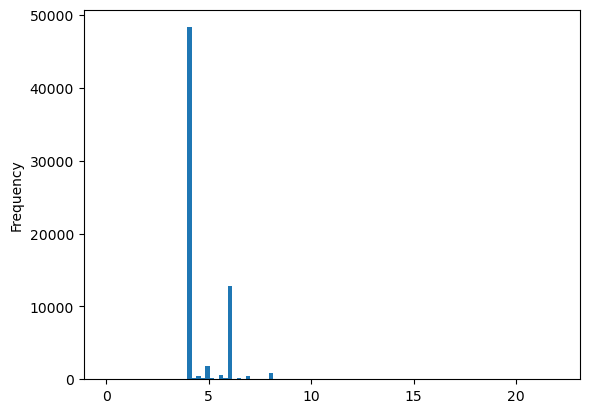

In [28]:
grouped_data.ssbCor.plot.hist(bins=100)

In [29]:
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
vals = scalar.fit_transform(grouped_data)
regional_ward_morphotopes_data = pd.DataFrame(vals, index=grouped_data.index, columns=grouped_data.columns)

regional_ward_morphotopes_data.loc[grouped_data['limLPS'] == 1, 'limLPS'] = 2

In [30]:
regional_ward_morphotopes_data.loc[['93167_159' , '91011_76', '69333_179']]

,sdbAre,sdbPer,sdbCoA,ssbCCo,ssbCor,ssbSqu,ssbERI,ssbElo,mtbSWR,libNCo,...,mibLen,mibElo,mibERI,mibCCo,mibLAL,mibFR,mibSCo,micBAD,midBAD,limLPS
93167_159,0.576278,0.678162,-0.003878,0.126992,1.457527,0.066072,-1.477216,0.830937,-0.930174,-0.073819,...,-0.181517,0.829667,0.554162,0.889968,-0.342951,-0.244149,-0.244149,-0.136021,-0.247615,2.0
91011_76,1.099949,1.350454,-0.003878,-1.080935,-0.544985,0.157445,0.183399,-0.155199,-0.930174,-0.073819,...,-0.146166,0.022774,0.830887,0.296214,-0.233768,-0.080452,-0.080452,0.019046,-0.064579,2.0
69333_179,9.864410,7.339213,-0.003878,-3.692230,0.456271,0.045745,-3.131234,-1.988120,-0.930174,-0.073819,...,0.259991,-1.152848,0.230155,-0.642648,0.889081,2.434666,2.434666,1.958408,0.729306,2.0


In [31]:
# import umap
# reducer = umap.UMAP(n_neighbors=25, n_components=20, 
#                     min_dist=0,
#                     metric='euclidean', verbose=True, random_state=1)
# embedding = reducer.fit_transform(regional_ward_morphotopes_data)
# embedding = pd.DataFrame(embedding, index=regional_ward_morphotopes_data.index)

### Final ward clustering

In [32]:
linkage = 'complete'
metric = 'euclidean'

In [33]:
%%time
linkage_matrix = get_morphotope_linkage(regional_ward_morphotopes_data)

CPU times: user 2min 26s, sys: 5.61 s, total: 2min 32s
Wall time: 2min 30s


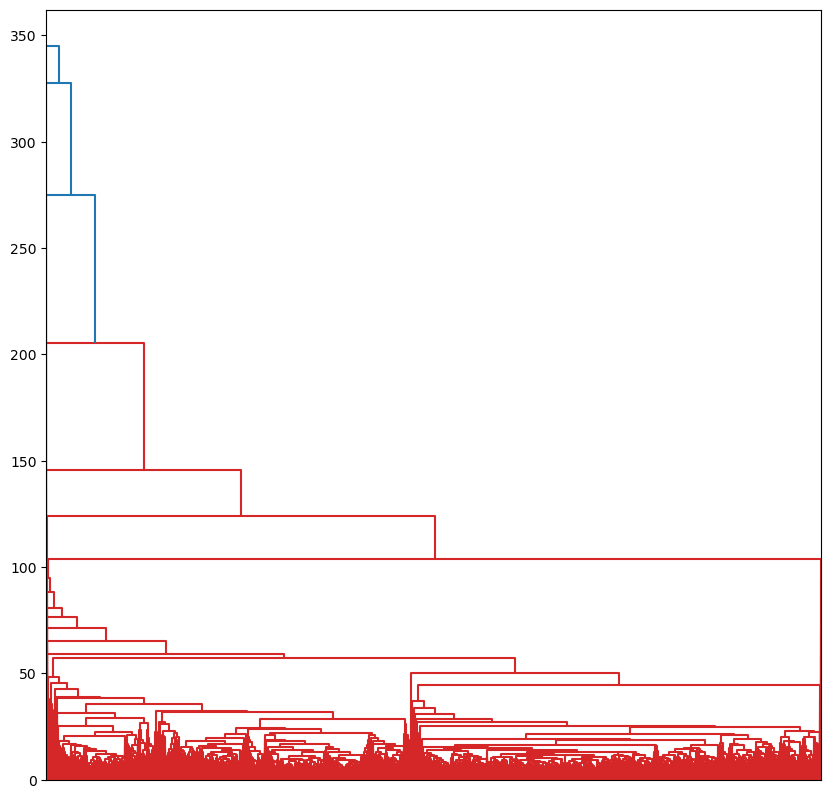

In [34]:
## final dendrogram
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
fig,ax = plt.subplots(figsize=(10,10))
_ = dendrogram(linkage_matrix,ax=ax, no_labels=True)

In [21]:
np.save(f'/data/uscuni-ulce/processed_data/morphotope_linkage/{linkage}_{metric}_full.npy', linkage_matrix)

In [23]:
grouped_data.to_parquet(f'/data/uscuni-ulce/processed_data/morphotope_linkage/regional_clusters_{regional_cutoff}_data.pq')

In [24]:
embedding.to_parquet(f'/data/uscuni-ulce/processed_data/morphotope_linkage/regional_clusters_{regional_cutoff}_embedding.pq')

In [27]:
regional_ward_morphotopes_data.to_parquet(f'/data/uscuni-ulce/processed_data/morphotope_linkage/regional_clusters_{regional_cutoff}_embedding_input.pq')

In [25]:
f'regional_clusters_{regional_cutoff}.csv'

'regional_clusters_2.5.csv'

In [32]:
regional_clusters.name='regional_cluster'
regional_clusters.to_frame().to_parquet(f'/data/uscuni-ulce/processed_data/morphotope_linkage/regional_clusters_{regional_cutoff}.pq')

In [28]:
regional_clusters

4_0_0               4_164
4_0_1               4_712
4_0_10              4_734
4_0_100             4_903
4_0_101            4_1837
                  ...    
152511_809_0    152511_10
152511_8_0      152511_20
152511_8_1      152511_39
152511_8_2      152511_20
152511_901_0    152511_31
Length: 523595, dtype: object

In [36]:
final_cutoff = 100

In [37]:
clusters = fcluster(linkage_matrix, t=final_cutoff, criterion='distance')
final_clusters = pd.Series(clusters, regional_ward_morphotopes_data.index)
# clusters_description = regional_ward_morphotopes_data.groupby(final_clusters).mean()
# clusters_description = grouped_data.groupby(final_clusters).mean()
final_clusters.value_counts()

7     66420
8        60
6         4
5         2
3         2
1         1
10        1
9         1
2         1
11        1
4         1
Name: count, dtype: int64

In [103]:
means = regional_ward_morphotopes_data.groupby(final_clusters).mean()

In [104]:
means.style.background_gradient(axis=0, cmap="BuGn")

,sdbAre,sdbPer,sdbCoA,ssbCCo,ssbCor,ssbSqu,ssbERI,ssbElo,mtbSWR,libNCo,ldbPWL,ltcBuA,mtbAli,mtbNDi,ltbIBD,stbSAl,sdsLen,sssLin,ldsMSL,ldsRea,ldsAre,sisBpM,sdsSPW,sdsSPO,sdsSWD,mtdDeg,lcdMes,linP3W,linP4W,linPDE,lcnClo,lddNDe,linWID,ldsCDL,xcnSCl,mtdMDi,sddAre,midRea,midAre,sdcLAL,sdcAre,sscCCo,sscERI,mtcWNe,mdcAre,ltcWRB,sicCAR,sdsAre,mibCou,mibAre,mibLen,mibElo,mibERI,mibCCo,mibLAL,mibFR,mibSCo,micBAD,midBAD,limLPS,limLPS2
1,0.645608,0.674538,0.001172,0.130047,0.700665,0.969196,0.169511,0.291333,0.951331,0.992799,0.989205,0.011917,0.537669,0.038587,0.066555,0.339942,0.245903,0.679891,0.229057,0.609122,0.297847,0.751628,0.078534,0.038735,0.305712,0.556827,0.777494,0.529853,0.711959,0.241558,0.670567,0.736284,0.777439,0.229762,0.395715,0.225395,0.226764,0.589588,0.282186,0.126475,0.131741,0.651765,0.412543,0.856892,0.156031,0.875566,0.988484,0.206251,0.987073,0.987888,0.990345,0.300907,0.008934,0.055351,0.985619,0.931209,0.931209,0.694272,0.656115,1.000000,1.000000
2,0.651656,0.657535,0.000000,0.380284,0.450417,0.560127,0.542789,0.352347,0.569110,0.001230,0.693829,0.393439,0.579406,0.548107,0.605954,0.586721,0.665757,0.422887,0.738770,0.594826,0.723438,0.384977,0.587566,0.645657,0.606419,0.544729,0.524651,0.561040,0.498696,0.453860,0.421723,0.257412,0.273626,0.552504,0.863344,0.684451,0.690995,0.620297,0.731026,0.625642,0.619327,0.422272,0.366684,0.369294,0.644078,0.394482,0.498943,0.656646,0.617242,0.692839,0.693755,0.355547,0.361961,0.300182,0.703397,0.685760,0.685760,0.700791,0.716983,1.000000,1.000000
3,0.482154,0.489867,0.000000,0.361543,0.558163,0.648912,0.376780,0.386904,0.826023,0.001601,0.813028,0.168519,0.361483,0.218157,0.230186,0.339065,0.312592,0.646085,0.296524,0.591286,0.345144,0.688768,0.290452,0.204863,0.433337,0.563899,0.764736,0.537828,0.680385,0.281352,0.607668,0.671118,0.712201,0.250987,0.851644,0.292006,0.291311,0.611856,0.354439,0.236809,0.218099,0.452715,0.502244,0.762886,0.232487,0.813115,0.851237,0.264255,0.826908,0.801542,0.813634,0.283677,0.197765,0.185982,0.806454,0.743410,0.743410,0.476028,0.461502,0.996982,0.996982
4,0.314489,0.309505,0.000000,0.672085,0.491619,0.398580,0.490321,0.684669,0.617439,0.000000,0.429625,0.412448,0.375371,0.341721,0.311797,0.417023,0.362601,0.543481,0.339490,0.495300,0.331802,0.618781,0.390528,0.316818,0.436039,0.543607,0.694678,0.583425,0.565637,0.363434,0.603110,0.632054,0.652170,0.287891,0.874861,0.336509,0.320515,0.563157,0.362203,0.295989,0.303800,0.466803,0.404376,0.712644,0.290705,0.766469,0.609695,0.302278,0.586537,0.421791,0.430630,0.662122,0.445108,0.579571,0.418052,0.407950,0.407950,0.390683,0.340900,0.997426,0.997426
5,0.718051,0.718306,0.000000,0.381934,0.391711,0.529287,0.635952,0.318185,0.526732,0.000000,0.690162,0.436206,0.629657,0.665260,0.705767,0.665341,0.788256,0.355777,0.828153,0.588464,0.798253,0.264229,0.654206,0.794887,0.664038,0.515201,0.347494,0.520991,0.417183,0.562377,0.352419,0.191484,0.192898,0.729555,0.001724,0.815972,0.809553,0.558750,0.795610,0.753338,0.743622,0.374098,0.330955,0.244330,0.759743,0.228434,0.336719,0.795320,0.587606,0.699815,0.689214,0.354043,0.432711,0.318420,0.705354,0.725564,0.725564,0.723196,0.762233,1.000000,1.000000
6,0.821975,0.837510,0.000000,0.195941,0.579029,0.560432,0.375816,0.240345,0.622821,0.014859,0.833869,0.334343,0.531554,0.640048,0.689621,0.500287,0.573842,0.504744,0.545031,0.449577,0.581366,0.325268,0.670808,0.613190,0.405185,0.497694,0.474124,0.516532,0.554616,0.453692,0.498208,0.488248,0.497124,0.534379,0.008959,0.589598,0.608652,0.413340,0.589634,0.731403,0.711041,0.360309,0.372131,0.272171,0.754569,0.294156,0.557119,0.604628,0.671682,0.843152,0.833140,0.242602,0.291102,0.220614,0.838113,0.858671,0.858671,0.865566,0.850690,1.000000,1.000000
7,0.424667,0.415160,0.000000,0.693784,0.457785,0.487860,0.480782,0.716877,0.561142,0.000000,0.494167,0.451731,0.678866,0.519431,0.529273,0.640112,0.404597,0.360754,0.496378,0.274895,0.390249,0.469896,0.432540,0.476253,0.558762,0.466029,0.328413,0.463262,0.317465,0.6

In [164]:
def get_embedding(data):
    reducer = umap.UMAP(n_neighbors=25, n_components=20, 
                        min_dist=0,
                        metric='euclidean', verbose=True, random_state=1)
    embedding = reducer.fit_transform(data)
    embedding = pd.DataFrame(embedding, index=data.index)
    return embedding

In [165]:
data = regional_ward_morphotopes_data
embedding = get_embedding(data)

data_embedding = embedding

/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(min_dist=0, n_components=20, n_jobs=1, n_neighbors=25, random_state=1, verbose=True)
Thu Jan 23 13:57:48 2025 Construct fuzzy simplicial set
Thu Jan 23 13:57:48 2025 Finding Nearest Neighbors
Thu Jan 23 13:57:48 2025 Building RP forest with 18 trees
Thu Jan 23 13:57:48 2025 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	Stopping threshold met -- exiting after 3 iterations
Thu Jan 23 13:57:52 2025 Finished Nearest Neighbor Search
Thu Jan 23 13:57:53 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Thu Jan 23 13:58:40 2025 Finished embedding


In [180]:
from sklearn.cluster import KMeans

data = regional_ward_morphotopes_data
data_embedding = embedding

clusterer = KMeans(2, random_state=1, n_init=500)
labels = clusterer.fit_predict(data_embedding)
clusters = pd.Series(labels, data.index)

In [ ]:
results = pd.DataFrame({'1': '1_' + clusters.astype(str) })
results

In [412]:
class DivisiveClustering:
    def __init__(self):
        self.labels_ = None
        self.linkage_matrix = None
        self.current_id = 0

    def fit(self, X):
        n_samples = X.shape[0]
        self.labels_ = np.zeros(n_samples, dtype=int)
        self.linkage_matrix = []
        self.current_id = n_samples
        
        # Start with all points in one cluster, initial recursion_level is 1
        self._recursive_split(X, np.arange(n_samples), 1)
        
        self.linkage_matrix = np.array(self.linkage_matrix)
        return self

    def _recursive_split(self, X, indices, recursion_level):
        if len(indices) <= 1:
            return indices[0], 1
        
        kmeans = KMeans(n_clusters=2)
        kmeans.fit(X[indices])
        
        mask0 = kmeans.labels_ == 0
        mask1 = kmeans.labels_ == 1
        indices0 = indices[mask0]
        indices1 = indices[mask1]
        
        id0, size0 = self._recursive_split(X, indices0, recursion_level + 1)
        id1, size1 = self._recursive_split(X, indices1, recursion_level + 1)
        
        # Use 1/recursion_level as distance
        distance = 1.0 / recursion_level
        
        self.linkage_matrix.append([float(min(id0, id1)), float(max(id0, id1)), 
                                  float(distance), float(size0 + size1)])
        
        current_cluster = self.current_id
        self.current_id += 1
        print(current_cluster)
        return current_cluster, size0 + size1

In [413]:
clusterer = DivisiveClustering()

In [414]:
# cluster_data = regional_ward_morphotopes_data[(regional_ward_morphotopes_data.index.str.startswith('69333') | 
#                                                regional_ward_morphotopes_data.index.str.startswith('91011') | 
#                                                regional_ward_morphotopes_data.index.str.startswith('93167'))]

cluster_data = regional_ward_morphotopes_data.copy()




In [415]:
%%time
clusterer.fit(cluster_data.values)

66494
66495
66496
66497
66498
66499
66500
66501
66502
66503
66504
66505
66506
66507
66508
66509
66510
66511
66512
66513
66514
66515
66516
66517
66518
66519
66520
66521
66522
66523
66524
66525
66526
66527
66528
66529
66530
66531
66532
66533
66534
66535
66536
66537
66538
66539
66540
66541
66542
66543
66544
66545
66546
66547
66548
66549
66550
66551
66552
66553
66554
66555
66556
66557
66558
66559
66560
66561
66562
66563
66564
66565
66566
66567
66568
66569
66570
66571
66572
66573
66574
66575
66576
66577
66578
66579
66580
66581
66582
66583
66584
66585
66586
66587
66588
66589
66590
66591
66592
66593
66594
66595
66596
66597
66598
66599
66600
66601
66602
66603
66604
66605
66606
66607
66608
66609
66610
66611
66612
66613
66614
66615
66616
66617
66618
66619
66620
66621
66622
66623
66624
66625
66626
66627
66628
66629
66630
66631
66632
66633
66634
66635
66636
66637
66638
66639
66640
66641
66642
66643
66644
66645
66646
66647
66648
66649
66650
66651
66652
66653
66654
66655
66656
66657
66658
66659
6666

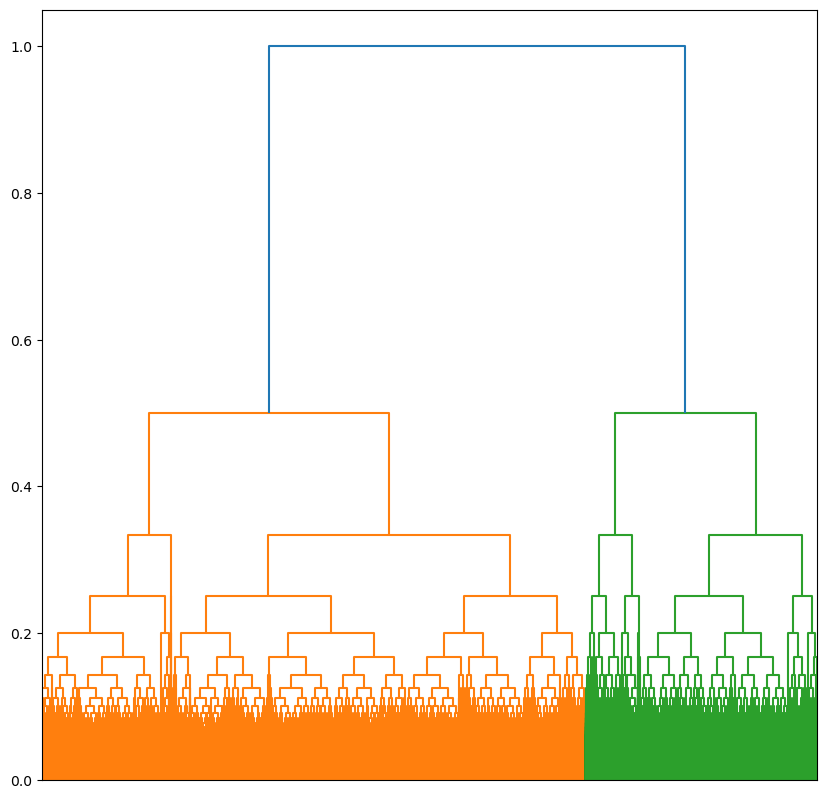

In [464]:
## final dendrogram
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
fig,ax = plt.subplots(figsize=(10,10))
_ = dendrogram(clusterer.linkage_matrix, ax=ax, no_labels=True)

In [540]:
final_cutoff = 1/6 -0.00001
clusters = fcluster(clusterer.linkage_matrix, t=final_cutoff, criterion='distance')
final_clusters = pd.Series(clusters, cluster_data.index)
final_clusters.value_counts()

16    5222
3     4710
19    4603
22    4189
17    3931
13    3495
14    3127
4     2402
50    2380
18    2244
2     2241
49    2174
24    2016
47    1980
44    1793
43    1461
45    1380
26    1284
12    1246
23    1081
46    1077
52    1050
38    1000
33     975
25     900
1      861
21     848
5      835
54     766
51     656
32     571
34     567
20     563
48     479
11     417
15     410
37     409
27     404
31     204
28     174
29     162
41      95
30      47
42      20
6       19
39      11
35       4
40       2
55       2
8        1
36       1
9        1
53       1
56       1
7        1
10       1
Name: count, dtype: int64

### Plotting

In [541]:
from core.cluster_validation import get_color
final_colors = pd.DataFrame(get_color(final_clusters.values), final_clusters.values).drop_duplicates()
final_colors.loc[-1] = [255,255,255]

In [542]:
region_id = 69333 

# region_id = 99886 # bratislava

# region_id = 151676 # vilnius

# region_id = 8707 # mainz/frankfurt
# region_id = 5883 #  freiburg
# region_id = 38679 #munich
# region_id = 55763 # berlin

# region_id = 86873 # vienna

# region_id = 107131 # krakow


# region_id= 66593

# region_id = 91011

In [543]:
# etcs=False to read buildings, etcs=True for tessellation cells.


# etcs = morphotopes_to_etcs(region_id, etcs=False, model_params=model_params)

In [544]:
etcs = morphotopes_to_etcs(69333, etcs=False, model_params=model_params)
etcs2 = morphotopes_to_etcs(91011, etcs=False, model_params=model_params)
etcs3 = morphotopes_to_etcs(93167, etcs=False, model_params=model_params)

etcs = pd.concat((etcs, etcs2, etcs3), ignore_index=True)

In [545]:



## relabel
### regional_clusters = morphotopes -> regional_clusters
### final_clusters = regional_clusters -> final_clusters
etcs['final'] = etcs['morph'].map(lambda x: final_clusters.loc[regional_clusters.loc[x]] if x in regional_clusters else -1)
etcs['regional'] = etcs['morph'].map(lambda x: regional_clusters.loc[x] if x in regional_clusters else "-1")



In [546]:
# ## can run this to change colors on an exisitng layer
# layer.get_fill_color = get_color(etcs.final)

In [547]:
etcs['geometry'] = etcs.simplify(1).to_crs(epsg=4326).make_valid()
etcs = etcs[etcs['geometry'].geom_type == 'Polygon']

In [ ]:
%%time
import lonboard
# plotting = tessellation[tessellation.index.isin(X_train.index)].copy()
layer = lonboard.SolidPolygonLayer.from_geopandas(etcs, opacity=.7)

In [ ]:
from sidecar import Sidecar
sc = Sidecar(title=f'Final Clusters - {final_cutoff}')
m = lonboard.Map(layer, basemap_style=lonboard.basemap.CartoBasemap.DarkMatter)
with sc:
    display(m)

In [ ]:
from core.cluster_validation import get_color
layer.get_fill_color = final_colors.loc[etcs.final].values.astype('uint8')

In [52]:
colorcodes = etcs['regional'].map(merged_clusters.to_dict()).fillna(-1)
layer.get_fill_color = merged_colors.loc[colorcodes].values.astype('uint8')
colorcodes.nunique()

NameError: name 'merged_colors' is not defined

In [442]:
etcs.final.value_counts().shape


(17,)

### Interactive dendro

In [478]:
linkage_matrix = clusterer.linkage_matrix

In [479]:
from core import interactive_dendrogram
import jscatter
import ipywidgets

scatter_df = interactive_dendrogram.get_dendrogram_scatter_data(linkage_matrix)
n = linkage_matrix.shape[0] + 1

def get_subcluster_children(focus):
    child, parent = linkage_matrix[focus - n, 0].astype(int), linkage_matrix[focus - n, 1].astype(int)
    children_ids = interactive_dendrogram.get_children(linkage_matrix, child, parent)
    children_morphotopes = regional_ward_morphotopes_data.iloc[children_ids].index
    return children_morphotopes

click_history = dict()
click_history_descriptions = dict()

In [482]:
scatter = jscatter.Scatter(data=scatter_df, x='x', y='y', height=640, width=1280)
scatter.axes(grid=True)
scatter.connect(by='group1', order='order1')
scatter.options({ 'pointConnectionTolerance': 1 })

# output = ipywidgets.Output()

# @output.capture(clear_output=True)
# def selection_change_handler(change):
#     display(scatter_df.loc[change.new].style.hide(axis='index'))
            
# scatter.widget.observe(selection_change_handler, names=["selection"])

# ipywidgets.HBox([scatter.show(), output])

In [483]:
scatter.show()

In [476]:
selected_node = scatter.selection()[0]


left = scatter_df.loc[selected_node, 'child'].astype(int)
right = scatter_df.loc[selected_node, 'parent'].astype(int)

left_children = get_subcluster_children(left)
right_children = get_subcluster_children(right)

cluster_colors = np.full((etcs.shape[0], 3), 0) # everything black
cluster_colors[etcs.regional.isin(left_children)] = [141,211,199] # left blue - 1
cluster_colors[etcs.regional.isin(right_children)] = [255,255,179] # right yellow - 2
layer.get_fill_color = cluster_colors.astype('uint8')

In [432]:
left_data = regional_ward_morphotopes_data.loc[left_children].mean()
right_data = regional_ward_morphotopes_data.loc[right_children].mean()
# assert np.isclose(pd.DataFrame({1:left_data, 2: right_data}).T.values, clusters_description.values).all()

diffs = (left_data - right_data)
diffs = diffs[(diffs ** 2).sort_values(ascending=False).index].head(20)
diffs

mtdDeg   -2.008590
linWID    1.620166
sdsSPO   -1.578583
mtbSWR    1.463171
ltcBuA   -1.353060
mtbNDi   -1.281014
mtbAli   -1.066860
sdsSPW   -1.039289
sdcAre   -1.037840
sdcLAL   -1.035507
sscERI   -1.034659
ldsAre   -1.024181
ldsMSL   -1.022198
midAre   -1.019047
mibERI   -0.906347
mdcAre   -0.904416
sscCCo   -0.851772
lddNDe    0.830976
mtcWNe    0.828024
midRea   -0.819065
dtype: float64

In [433]:
selected_node

np.uint32(132985)

In [434]:
used_keys['ldsRea']

'reached ETCs by local street network'

In [457]:
## save for cutting...
click_history[selected_node] = diffs

In [458]:
click_history_descriptions[selected_node] = f'{region_id} seperate smaller blocks and villages'

In [459]:
click_history_descriptions

{np.uint32(31798): 'seperate rowhouses and vinohrady',
 np.uint32(29569): 'seperate smaller structures and vinohrady',
 np.uint32(124136): 'seperate smaller blocks and smaller industry',
 np.uint32(39767): '55763 seperate smaller blocks and smaller industry in germany',
 np.uint32(115401): '69333 seperate smaller blocks and villages',
 np.uint32(46460): '66593 seperate smaller blocks and villages',
 np.uint32(125887): '151676 seperate smaller blocks and villages'}

In [37]:
click_history_descriptions = {np.uint32(31798): 'seperate rowhouses and vinohrady',
 np.uint32(29569): 'seperate smaller structures and vinohrady',
 np.uint32(124136): 'seperate smaller blocks and smaller industry',
 np.uint32(39767): '55763 seperate smaller blocks and smaller industry in germany',
 np.uint32(115401): '69333 seperate smaller blocks and villages',
 np.uint32(46460): '66593 seperate smaller blocks and villages',
 np.uint32(125887): '151676 seperate smaller blocks and villages'}

In [38]:
## assign clusters

In [39]:
clusters = fcluster(linkage_matrix, t=final_cutoff, criterion='distance')
final_clusters = pd.Series(clusters, regional_ward_morphotopes_data.index)

grouping = pd.DataFrame()
grouping[final_cutoff] = final_clusters.astype(str)

In [40]:


# for selected_node in [6421, 6887, 28557, 15017, 35908]: - hierarchy without lithuania


for selected_node in click_history_descriptions.keys():
    left = scatter_df.loc[selected_node, 'child'].astype(int)
    right = scatter_df.loc[selected_node, 'parent'].astype(int)
    
    left_children = get_subcluster_children(left)
    right_children = get_subcluster_children(right)
    
    grouping.loc[left_children, round(scatter_df.loc[selected_node, 'dist'], 2)] = str(selected_node) + '1'
    grouping.loc[right_children, round(scatter_df.loc[selected_node, 'dist'], 2)] = str(selected_node) + '2'

In [41]:
ordered_columns = grouping.columns.sort_values()
grouping = grouping[ordered_columns]

# forward cluster breakdowns to higher levels
for i, col in enumerate(ordered_columns[:-1]):
    grouping.iloc[grouping[col].notna().values, i + 1] = grouping.loc[grouping[col].notna(), col]  

In [42]:
merged_clusters = grouping[final_cutoff]
merged_clusters.factorize()

(array([ 0,  1,  2, ..., 22,  7,  7]),
 Index(['13', '14', '7', '6', '11', '317982', '24', '3', '2', '8', '5', '17',
        '21', '25', '1258872', '23', '464601', '1154012', '1241362', '16',
        '295691', '1', '295692', '4', '18', '1241361', '15', '10', '1258871',
        '464602', '9', '20', '397672', '397671'],
       dtype='object'))

In [465]:

merged_clusters = pd.Series(merged_clusters.factorize()[0], merged_clusters.index)

In [466]:
merged_colors = pd.DataFrame(get_color(merged_clusters.values), merged_clusters.values).drop_duplicates()
merged_colors.loc[-1] = [255,255,255]

In [467]:
colorcodes = etcs['regional'].map(merged_clusters.to_dict()).fillna(-1)
layer.get_fill_color = merged_colors.loc[colorcodes].values.astype('uint8')

In [468]:
click_history_descriptions

{np.uint32(31798): 'seperate rowhouses and vinohrady',
 np.uint32(29569): 'seperate smaller structures and vinohrady',
 np.uint32(124136): 'seperate smaller blocks and smaller industry',
 np.uint32(39767): '55763 seperate smaller blocks and smaller industry in germany',
 np.uint32(115401): '69333 seperate smaller blocks and villages',
 np.uint32(46460): '66593 seperate smaller blocks and villages',
 np.uint32(125887): '151676 seperate smaller blocks and villages'}

In [469]:
scatter_df.loc[click_history_descriptions.keys()]

,child,parent,dist,size,x,y,group1,order1
31798,132691.0,132918.0,1.819189,2692.0,5.975272e+05,1.819189,66443.0,2
29569,132013.0,132641.0,0.946188,463.0,5.866530e+05,0.946188,66443.0,3
124136,132544.0,132880.0,1.797646,965.0,1.141552e+06,1.797646,66477.0,3
39767,132211.0,132332.0,0.857903,557.0,7.885529e+05,0.857903,66116.0,2
115401,132879.0,132939.0,1.887804,3016.0,9.359880e+05,1.887804,66474.0,1
46460,132727.0,132833.0,1.370760,568.0,9.230535e+05,1.370760,66449.0,3
125887,132758.0,132815.0,1.600071,1058.0,1.175755e+06,1.600071,66438.0,1


In [470]:
merged_clusters.value_counts().sort_index()

0     2304
1     4443
2     3036
3     1437
4     3061
5     2229
6     3280
7     2568
8     1067
9     3655
10    2705
11    2713
12    5131
13    2270
14     560
15    2237
16     351
17    2448
18     665
19     850
20     262
21     836
22     201
23    3291
24    2646
25     300
26     580
27    3142
28     498
29     217
30    4314
31    2640
32     354
33     203
Name: count, dtype: int64

In [477]:
v = 'v2'

In [478]:
pd.Series(click_history_descriptions).to_csv(f'/data/uscuni-ulce/processed_data/clusters/manual_cuts_{v}.csv')

In [479]:
merged_clusters.to_frame().to_parquet(f'/data/uscuni-ulce/processed_data/clusters/clusters_{v}.pq')

In [480]:
final_clusters = pd.read_parquet(f'/data/uscuni-ulce/processed_data/clusters/clusters_{v}.pq')[0]
cdata = grouped_data.groupby(final_clusters).median().fillna(0)
cdata.to_parquet(f'/data/uscuni-ulce/processed_data/clusters/cdata_{v}.pq')

/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pandas/io/parquet.py:480: UserWarning: The DataFrame has non-str index name `[np.int64(0)]` which will be converted to string and not roundtrip correctly.
  impl.write(


### hierarchy of final clusters

In [ ]:
fdata = grouped_data.groupby(merged_clusters).median().fillna(0)


In [707]:
fdata.to_parquet('../data/cluster_data.pq')


In [600]:
fdata = grouped_data.groupby(merged_clusters).median().fillna(0)
scalar = StandardScaler()
vals = scalar.fit_transform(fdata)
fdata = pd.DataFrame(vals, index=fdata.index, columns=fdata.columns)

In [601]:
linkage = 'complete'
metric = 'euclidean'
linkage_matrix = get_morphotope_linkage(fdata)

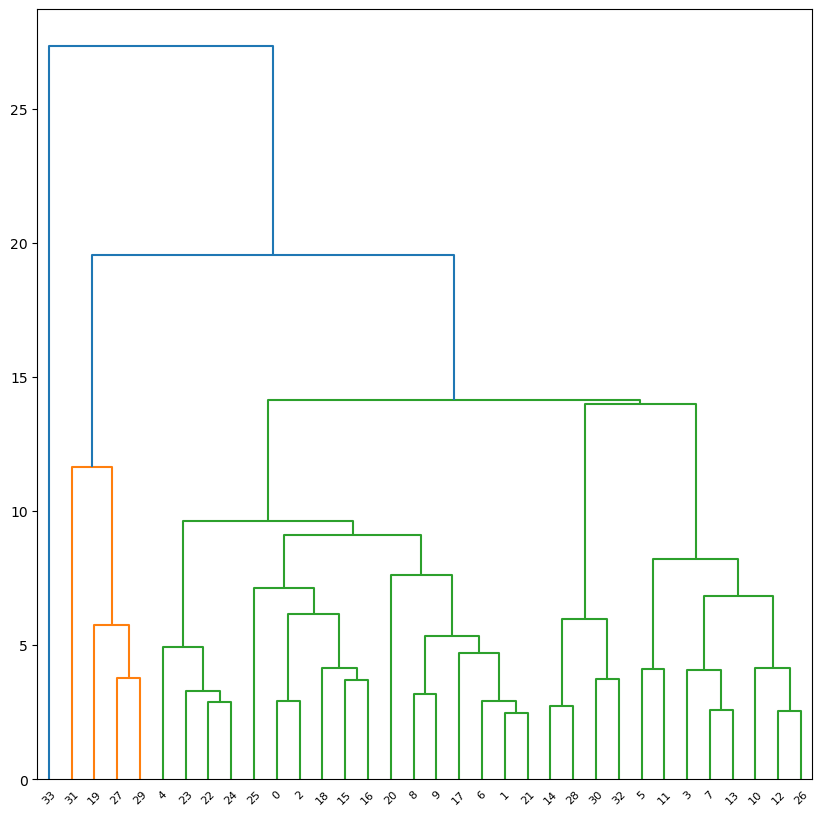

In [602]:
## final dendrogram
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
fig,ax = plt.subplots(figsize=(10,10))
_ = dendrogram(linkage_matrix,ax=ax)

In [622]:
etcs[etcs.final == 28].explore(prefer_canvas=True, tiles='cartodb.positron')

In [574]:
final_cutoff = 8
clusters = fcluster(linkage_matrix, t=final_cutoff, criterion='distance')
final_clusters = pd.Series(clusters, fdata.index)
final_clusters.value_counts()

5    7
4    6
8    6
3    4
6    4
1    3
7    2
2    1
9    1
Name: count, dtype: int64

### assign to etcs

In [405]:
from core.cluster_validation import get_color
merged_colors = pd.DataFrame(get_color(merged_clusters.values), merged_clusters.values).drop_duplicates()
merged_colors.loc[-1] = [255,255,255]

In [406]:
region_id = 151676

In [407]:
# etcs=False to read buildings, etcs=True for tessellation cells.
etcs = morphotopes_to_etcs(region_id, etcs=False, model_params=model_params)
etcs.shape

(321417, 16)

In [408]:
# region_hulls.explore()

In [409]:



## relabel
### regional_clusters = morphotopes -> regional_clusters
### final_clusters = regional_clusters -> final_clusters
etcs['final'] = etcs['morph'].map(lambda x: merged_clusters.loc[regional_clusters.loc[x]] if x in regional_clusters else -1)
etcs['regional'] = etcs['morph'].map(lambda x: regional_clusters.loc[x] if x in regional_clusters else "-1")

In [410]:
# etcs['final'] = etcs.final.map(final_clusters).values

In [411]:
region_hulls

,convex_hull
labels,
4,"POLYGON ((4122200 3045600, 4121500 3045900, 40..."
10,"POLYGON ((4068900 3057300, 4051000 3064300, 40..."
132,"POLYGON ((4053100 3049800, 4050900 3053000, 40..."
134,"POLYGON ((4052500 3093600, 4052200 3093700, 40..."
286,"POLYGON ((4060600 3103900, 4057000 3104200, 40..."
...,...
149997,"POLYGON ((5253200 3642300, 5245600 3647000, 52..."
150044,"POLYGON ((5265700 3578300, 5263400 3578400, 52..."
151676,"POLYGON ((5285400 3549200, 5284800 3549900, 52..."


In [412]:
%%time
import lonboard
# plotting = tessellation[tessellation.index.isin(X_train.index)].copy()
layer = lonboard.SolidPolygonLayer.from_geopandas(etcs, opacity=.7)

from sidecar import Sidecar
sc = Sidecar(title=f'Final Clusters')
m = lonboard.Map(layer, basemap_style=lonboard.basemap.CartoBasemap.DarkMatter)
with sc:
    display(m)

from core.cluster_validation import get_color
layer.get_fill_color = merged_colors.loc[etcs.final].values.astype('uint8')

/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/lonboard/_geoarrow/ops/reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")


CPU times: user 1.63 s, sys: 199 ms, total: 1.83 s
Wall time: 1.81 s


In [413]:
# layer.get_fill_color = get_color(etcs.final.map(final_clusters).values.astype(int))

In [414]:
etcs.final.nunique()

17

In [780]:
etcs.to_parquet(f'/data/uscuni-ulce/processed_data/clusters/{region_id}_clusters.pq')

In [403]:
merged_colors.shape

(33, 3)

## Assign all regions

In [482]:
v = 'v2'
merged_clusters = pd.read_parquet(f'/data/uscuni-ulce/processed_data/clusters/clusters_{v}.pq')[0]
merged_clusters.nunique()

34

In [483]:
%%time
for region_id, _ in region_hulls.iterrows():
    print(region_id)
    etcs = morphotopes_to_etcs(region_id, etcs=False, model_params=model_params)
    etcs['final'] = etcs['morph'].map(lambda x: merged_clusters.loc[regional_clusters.loc[x]] if x in regional_clusters else -1)
    etcs['regional'] = etcs['morph'].map(lambda x: regional_clusters.loc[x] if x in regional_clusters else "-1")
    etcs.to_parquet(f'/data/uscuni-ulce/processed_data/clusters/{region_id}_clusters.pq')

4
10
132
134
286
313
400
523
765
801
832
913
960
1124
1154
1387
1478
1515
1605
1718
1736
1782
1970
1981
2096
2322
2350
2478
2514
2625
2728
2975
3039
3109
3150
3221
3250
3526
3610
3612
3701
3705
3752
3759
3981
4070
4214
4215
4235
4284
4356
4382
4723
4805
5096
5191
5246
5310
5408
5427
5662
5671
5766
5883
6254
6529
6560
6576
6741
6749
6811
6873
6996
7068
7094
7280
7485
7528
7534
7681
7688
7712
7727
7805
7914
7937
7963
8046
8216
8238
8256
8265
8345
8374
8396
8592
8707
8731
8757
8759
8813
9016
9064
9074
9150
9169
9194
9284
9824
9924
9954
9972
10019
10086
10095
10124
10179
10222
10263
10277
10455
10510
10511
10563
10579
10602
10666
10794
10847
10908
10926
10970
11002
11019
11057
11141
11210
11256
11261
11305
11309
11311
11318
11367
11444
11455
11471
11667
11678
11735
11757
11799
11877
11905
12027
12084
12100
12115
12154
12191
12381
12440
12483
12552
12667
12707
12755
12756
12844
12919
12965
13076
13137
13172
13191
13196
13229
13301
13395
13442
13482
13506
13553
13555
13614
13616
13655
13677


### Tree comparisons

In [224]:
from sklearn.neighbors import KDTree

In [225]:
tree = KDTree(regional_ward_morphotopes_data.values)

In [527]:
dists, idxs = tree.query(regional_ward_morphotopes_data.loc[['69333_66']], k=100)

In [528]:
regional_ward_morphotopes_data.iloc[idxs[0]].index

Index(['69333_66', '62954_18', '114311_66', '35141_1', '97745_5', '78792_11',
       '1154_19', '109491_60', '105385_4', '107131_445', '97745_3',
       '105090_15', '78938_32', '93793_17', '72396_10', '61183_2', '116866_31',
       '107131_447', '86873_39', '67156_11', '62954_16', '83538_29',
       '80404_68', '18557_91', '51289_3', '130658_17', '64220_42', '75642_5',
       '62193_4', '90196_6', '87947_3', '93167_16', '73611_9', '107131_441',
       '114311_65', '84554_38', '108884_27', '1154_18', '61187_17',
       '109491_63', '110908_2', '103561_13', '107131_456', '90770_55',
       '67803_4', '93504_7', '82514_3', '120961_8', '114311_64', '78938_31',
       '53525_2', '86863_4', '116866_32', '97745_6', '90075_1', '93793_10',
       '103713_6', '88950_2', '96465_1', '97978_10', '84962_7', '128286_16',
       '93167_15', '109491_59', '80313_11', '102814_9', '84420_6', '55763_24',
       '85156_4', '89921_2', '72507_21', '76038_20', '129730_34', '82773_14',
       '96727_11', '7547

In [139]:
# etcs[etcs.regional == '69333_64'].explore()

## BRNO comparisons

In [34]:
regions = [91011, 88950, 84297,85104,83538,86568,93167,97978,96895,100210,98107]
etcs = pd.concat([gpd.read_parquet(f"/data/uscuni-ulce/processed_data/clusters/{region_id}_clusters.pq") for region_id in regions])

In [37]:
etcs= etcs.merge(embedding, how="left", left_on="regional", right_index=True)

In [38]:
etcs

,currentUse,buildingNature,heightAboveGround,iid,geometry,label,morph,final,regional,final_without_noise,...,10,11,12,13,14,15,16,17,18,19
0,None,None,NaN,80687654,"POLYGON ((4764127.215 3003366.261, 4764134.755...",0,91011_0_-1,-1,-1,26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,None,None,NaN,80724885,"POLYGON ((4779189.412 2981469.524, 4779193.147...",214,91011_1_0,26,91011_28,26,...,4.391919,5.434757,6.202294,4.747689,4.97861,3.641655,4.727001,5.708712,6.774211,4.25083
2,None,None,NaN,80724886,"POLYGON ((4779132.331 2981292.364, 4779148.597...",214,91011_1_0,26,91011_28,26,...,4.391919,5.434757,6.202294,4.747689,4.97861,3.641655,4.727001,5.708712,6.774211,4.25083
3,None,None,NaN,80724887,"POLYGON ((4779561.295 2981425.951, 4779563.643...",215,91011_1_1,26,91011_28,26,...,4.391919,5.434757,6.202294,4.747689,4.97861,3.641655,4.727001,5.708712,6.774211,4.25083
4,None,None,NaN,80724888,"POLYGON ((4778592.213 2981125.266, 4778612.884...",214,91011_1_0,26,91011_28,26,...,4.391919,5.434757,6.202294,4.747689,4.97861,3.641655,4.727001,5.708712,6.774211,4.25083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91464,None,None,NaN,84876273,"POLYGON ((4843315.24 3028458.881, 4843315.494 ...",73,98107_1058_-1,-1,-1,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91465,None,None,NaN,84876290,"POLYGON ((4837503.796 3024621.797, 4837510.316...",77,98107_1060_-1,-1,-1,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91466,None,None,NaN,84876346,"POLYGON ((4841431.281 3030256.391, 4841433.122...",78,98107_1061_-1,-1,-1,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91467,None,None,NaN,84876422,"POLYGON ((4839103.222 3027954.066, 4839106.231...",79,98107_1062_-1,-1,-1,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
no_noise = etcs[etcs.final >-1] 

In [73]:
import lonboard
layer = lonboard.SolidPolygonLayer.from_geopandas(no_noise)

from sidecar import Sidecar
sc = Sidecar(title=f'Final Clusters')
m = lonboard.Map(layer, basemap_style=lonboard.basemap.CartoBasemap.Positron)
with sc:
    display(m)

/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/lonboard/_geoarrow/geopandas_interop.py:20: UserWarning: The DataFrame has column names of mixed type. They will be converted to strings and not roundtrip correctly.
  table = pa.Table.from_pandas(df_attr, preserve_index=preserve_index)
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/lonboard/_geoarrow/ops/reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")


In [64]:
from lonboard.colormap import apply_continuous_cmap
from palettable.matplotlib import Viridis_20

i = 3
col_vals = (no_noise[i] - no_noise[i].min()) / (no_noise[i].max() - no_noise[i].min())

layer.get_fill_color = apply_continuous_cmap(
    col_vals, Viridis_20
)

<Axes: ylabel='Frequency'>

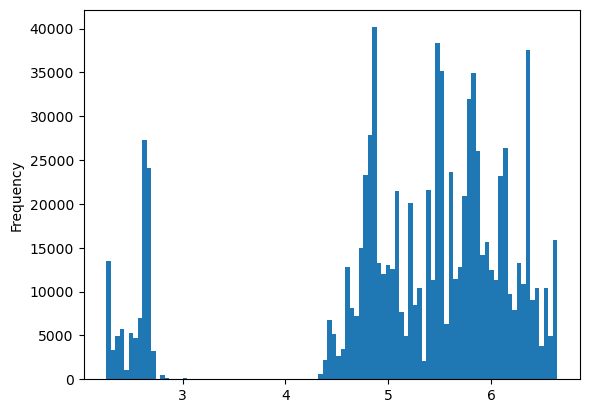

In [65]:
etcs[i].plot.hist(bins=100)

In [ ]:
etcs